In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import matplotlib.image as mpimg
from imutils import paths
import sys
import operator

In [3]:
!pip install rich
!pip install hydra-core
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.2 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.4 MB/s 
     |████████████████████████████████| 117 kB 64.0 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=d3d296b4550505448231a74b9f4389deb5c49faa89f0dcb7a77569074b0be8d1
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 5.1 MB/s 
     |████████████████████████████████| 419 kB 57.7 MB/s 
     |████████████████████████████████| 5.9 MB 59.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [5]:
import pytorch_lightning as pl
from src.utils.display_image_from_path import img_show
from src.utils.display_image_from_array import img_show_from_arr

In [6]:
img = cv2.imread("/content/drive/MyDrive/Datasets/mask-image/original/7.png")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [7]:
img_mask = cv2.imread("/content/drive/MyDrive/Datasets/mask-image/labels/7.png")

In [24]:
img_mask[157][1305]

array([255, 255, 255], dtype=uint8)

In [9]:
from torchvision import transforms

In [25]:
h, w, d = img_mask.shape
binary_mask = img_mask.copy()
binary_mask[157][1305]

array([255, 255, 255], dtype=uint8)

In [26]:
for i in range(h):
  for j in range(w):
    for k in range(d):
       binary_mask[i][j][k] = 1 if binary_mask[i][j][k] == 255 else 0


In [27]:
binary_mask[157][1305]

array([1, 1, 1], dtype=uint8)

In [28]:
def next_neighbor_as_zero(height, width, mask):

  pixels_having_0_as_neighbor = []
  i, j = 5, 5

  for i in range(height):
    for j in range(width):
      if mask[i][j][0] == 1:
        if mask[i-1][j][0] == 0: # downstairs neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i][j-1][0] == 0: # left neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i+1][j][0] == 0: # upstairs neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i][j+1][0] == 0: # right neighbor
          pixels_having_0_as_neighbor.append((i, j))
  return pixels_having_0_as_neighbor

In [29]:
neighbor0_pixels = next_neighbor_as_zero(h, w, binary_mask)
neighbor_mask = np.zeros(binary_mask.shape)

In [30]:
len(neighbor0_pixels)

195473

In [31]:
x = neighbor0_pixels[0]
x[0]

34

In [32]:
for coord in neighbor0_pixels:
  neighbor_mask[coord[0]][coord[1]][0] = 255
  neighbor_mask[coord[0]][coord[1]][1] = 255
  neighbor_mask[coord[0]][coord[1]][2] = 255

In [ ]:
img_show_from_arr(neighbor_mask)

In [ ]:
neighbor0_pixels[:100]

In [ ]:
neighbor0_pixels[100:200]

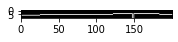

In [ ]:
img_show_from_arr(neighbor_mask[30:40, 350:550, :])

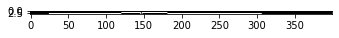

In [46]:
neighbor0_pixels = np.array(neighbor0_pixels)
neighbor0_pixels[0][0]

34

In [49]:
rows_in_neighbor0_pixels = []
for coord in neighbor0_pixels:
  rows_in_neighbor0_pixels.append(coord[0])
len(rows_in_neighbor0_pixels)

195473

In [51]:
unique_rows_in_neighbor0_pixels = np.unique(rows_in_neighbor0_pixels)

In [52]:
len(unique_rows_in_neighbor0_pixels)

3253

In [53]:
img.shape

(3728, 2880, 3)

In [54]:
import collections


In [65]:
counter = collections.Counter(rows_in_neighbor0_pixels)
counter.most_common(10)

[(2166, 1829),
 (1163, 1819),
 (1242, 1816),
 (2138, 1816),
 (1135, 1791),
 (1270, 1789),
 (2773, 841),
 (2744, 839),
 (232, 675),
 (214, 662)]

In [68]:
counter[2166]

1829

In [86]:
most_likely_line_pixels = []
for row in unique_rows_in_neighbor0_pixels:
  if counter[row] > img.shape[1] * 0.5 :  
    most_likely_line_pixels.append(row)

In [87]:
len(most_likely_line_pixels)

6

In [88]:
most_likely_line_pixels

[1135, 1163, 1242, 1270, 2138, 2166]

In [95]:
line_coords = []
for x in most_likely_line_pixels:
  for coord in neighbor0_pixels:
    if coord[0] == x:
      line_coords.append(coord)

len(line_coords)

10860

In [97]:
lines = np.zeros(img.shape)
for coord in line_coords:
  lines[coord[0]][coord[1]][0] = 1
  lines[coord[0]][coord[1]][1] = 1
  lines[coord[0]][coord[1]][2] = 1